## 🧩 Classification Task — K-Nearest Neighbors (KNN)

In this section, we apply the **K-Nearest Neighbors (KNN)** algorithm to the **MAGIC Gamma Telescope** dataset.

The objective is to classify events as either **Gamma (signal)** or **Hadron (background)** based on the provided features.

We will perform two implementations:

1. **Manual KNN Implementation**  
   - Compute Euclidean distances manually.  
   - Identify the *k* nearest neighbors.  
   - Predict based on majority voting.  
   - Experiment with different values of *k* to study underfitting and overfitting trends.

2. **Scikit-Learn KNN Implementation**  
   - Use `sklearn.neighbors.KNeighborsClassifier`.  
   - Compare its performance with the manual approach.  

We will evaluate and compare both models using:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**
- **Confusion Matrix**

Finally, we will plot **Validation Accuracy vs. K values** for both models and discuss the optimal *k* value.


### Importing necessary libs

In [104]:
import os
import sys
import numpy as np
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)
import importlib
import src.plots
importlib.reload(src.plots)


from src.utils import load_dataset,split_data,classification_metrics,regression_metrics
from src.plots import  plot_validation_curve ,plot_single_cat, show_heatmap

### Performing some EDA

In [105]:
df = load_dataset("../data/telescope_data/telescope_data.csv")
df.info()
df.describe(include='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19020 non-null  int64  
 1   fLength     19020 non-null  float64
 2   fWidth      19020 non-null  float64
 3   fSize       19020 non-null  float64
 4   fConc       19020 non-null  float64
 5   fConc1      19020 non-null  float64
 6   fAsym       19020 non-null  float64
 7   fM3Long     19020 non-null  float64
 8   fM3Trans    19020 non-null  float64
 9   fAlpha      19020 non-null  float64
 10  fDist       19020 non-null  float64
 11  class       19020 non-null  object 
dtypes: float64(10), int64(1), object(1)
memory usage: 1.7+ MB


,class
count,19020
unique,2
top,g
freq,12332


In [106]:
df.head(10)

,Unnamed: 0,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
5,5,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
6,6,48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.0870,g
7,7,26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.1340,g
8,8,96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.2260,g
9,9,46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.2510,g


#### we may notice imbalance between the two target categories

* let's do some visualization

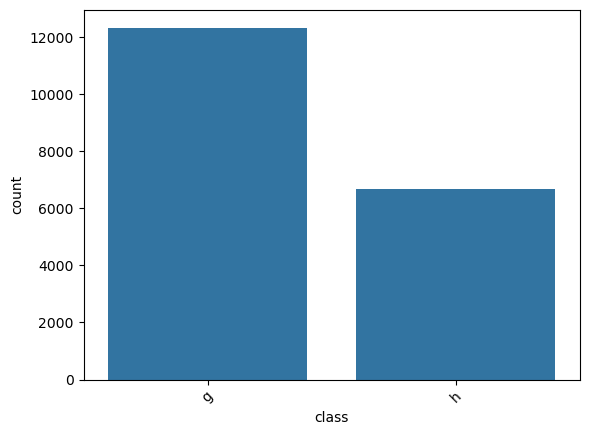

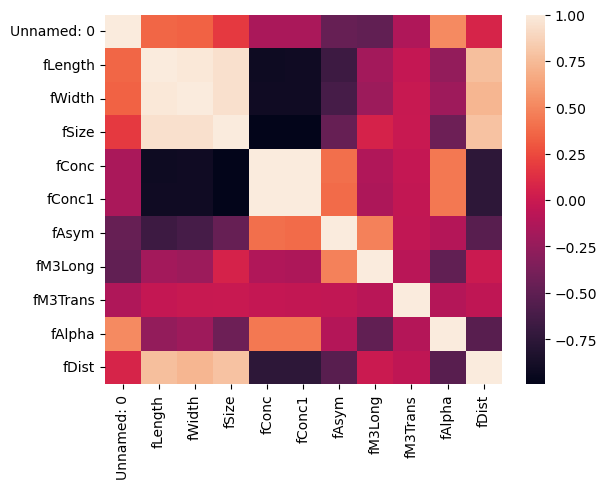

In [107]:
plot_single_cat("class", df)
numeric_df = df.select_dtypes(include=['number'])
show_heatmap(numeric_df.corr())


we may notice some feature are highly correlated

let's drop them out


In [108]:
corr_matrix = df.drop(columns=['class']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_reduced = df.drop(columns=to_drop)
df_reduced['class'] = df_reduced['class'].map({'g': 0, 'h': 1})

df_reduced.head(10)


,Unnamed: 0,fLength,fWidth,fSize,fConc,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,0,28.7967,16.0021,2.6449,0.3918,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,1,31.6036,11.7235,2.5185,0.5303,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,2,162.0520,136.0310,4.0612,0.0374,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,3,23.8172,9.5728,2.3385,0.6147,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,4,75.1362,30.9205,3.1611,0.3168,-5.5277,28.5525,21.8393,4.6480,356.4620,0
5,5,51.6240,21.1502,2.9085,0.2420,50.8761,43.1887,9.8145,3.6130,238.0980,0
6,6,48.2468,17.3565,3.0332,0.2529,8.5730,38.0957,10.5868,4.7920,219.0870,0
7,7,26.7897,13.7595,2.5521,0.4236,29.6339,20.4560,-2.9292,0.8120,237.1340,0
8,8,96.2327,46.5165,4.1540,0.0779,110.3550,85.0486,43.1844,4.8540,248.2260,0
9,9,46.7619,15.1993,2.5786,0.3377,24.7548,43.8771,-6.6812,7.8750,102.2510,0


### Balancing Data and Splitting

In [ ]:
features = df_reduced.drop('class', axis = 1)
y = df_reduced["class"]

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

X_train, X_val, X_test, y_train, y_val, y_test = split_data(features, y)

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
y_train = y_train.reset_index(drop=True)
print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)



class
0    0.64837
1    0.35163
Name: proportion, dtype: float64
class
0    0.5
1    0.5
Name: proportion, dtype: float64


### now it's time to predict

In [132]:
# Reload both files
importlib.reload(src.knn_manual)
importlib.reload(src.utils)


<module 'src.utils' from '/Users/mac/Studying/Machine learning/KNN_Linear_regression_manual_built-in/assignment_1/src/utils.py'>

In [133]:

# Re-import after reload
from src.utils import evaluate_knn_for_ks
from src.knn_manual import KNN_predict



ks = [1,3,5,7,9]
results = evaluate_knn_for_ks(X_train,y_train,X_val,y_val,ks)
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)


meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): Index([8482, 10572, 4868, 6982, 7554, 12145, 6437, 1517, 11460, 5472], dtype='int64')
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): Index([8482, 10572, 4868, 6982, 7554, 12145, 6437, 1517, 11460, 5472], dtype='int64')
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): Index([8482, 10572, 4868, 6982, 7554, 12145, 6437, 1517, 11460, 5472], dtype='int64')
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Series'>
First few indices of y_train (if Series): Index([8482, 10572, 4868, 6982, 7554, 12145, 6437, 1517, 11460, 5472], dtype='int64')
First few values of y_train: [0 0 0 0 0 0 0 0 0 0]
meow
Type of y_train: <class 'pandas.core.series.Ser

/opt/anaconda3/envs/qattan/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/qattan/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/qattan/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda